In [ ]:
import os
os.chdir('..')

In [1]:
from src.data_peparation import get_q2data
from sklearn.model_selection import train_test_split
import xgboost as xgb
import json
import pandas as pd
from sklearn.metrics import r2_score

In [ ]:
df_pivot = get_q2data()

# Lista de estaciones, contaminantes y períodos de predicción
forecast_targets = [
    (206, "SO2", "2023-07-01", "2023-08-01", 3),
    (211, "NO2", "2023-08-01", "2023-09-01", 3),
    (217, "O3", "2023-09-01", "2023-10-01", 3),
    (219, "CO", "2023-10-01", "2023-11-01", 1),
    (225, "PM10", "2023-11-01", "2023-12-01", 0),
    (228, "PM2.5", "2023-12-01", "2024-01-01", 0),
]

predictions = {"target": {}}

for t in forecast_targets:
    target = t[1] +"_" + str(t[0])
    station = t[0]
    start_date = t[2]
    end_date = t[3]
    decimals = t[4]

    df_model = df_pivot.copy()
    df_model.dropna(subset=[target], inplace=True)

    features = df_model.drop(columns=["Measurement date", target])
    X = features.values
    y = df_model[target].values


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        objective='reg:squarederror'
    )

    model.fit(
        X_train,
        y_train,
        verbose=50
        )
    y_pred = model.predict(X_test)

    #print r2 score

    r2 = r2_score(y_test, y_pred)
    print(f"R2 Score: {r2:.4f}")

    df_pivot["Measurement date"] = pd.to_datetime(df_pivot["Measurement date"])
    mask = (df_pivot["Measurement date"] >= start_date) & (df_pivot["Measurement date"] < end_date)
    df_filtered = df_pivot.loc[mask].reset_index(drop=True)
    future_dates = df_filtered["Measurement date"]
    df_filtered.drop(columns=["Measurement date"], inplace=True)
    y_pred = model.predict(df_filtered.drop(columns=[target])).flatten().tolist()

    # interpolación
    df_interpolation = pd.DataFrame({"Measurement date": future_dates, "Prediction": y_pred})
    df_interpolation = df_interpolation.set_index("Measurement date")
    df_interpolation = df_interpolation.resample("h").asfreq().reset_index()
    df_interpolation["Prediction_"] = df_interpolation["Prediction"].interpolate(method="linear")
    future_dates = df_interpolation["Measurement date"]
    y_pred = df_interpolation["Prediction_"].tolist()

    predictions["target"][str(station)] = {str(date): round(val, decimals) for date, val in zip(future_dates, y_pred)}

# Guardar el output en un archivo JSON
output_path = "predictions/predictions_task_2.json"
with open(output_path, "w") as f:
    json.dump(predictions, f, indent=2)

print(f"Predicciones guardadas en {output_path}")

R2 Score: 0.8398
Predicciones guardadas en predictions/predictions_task_2.json


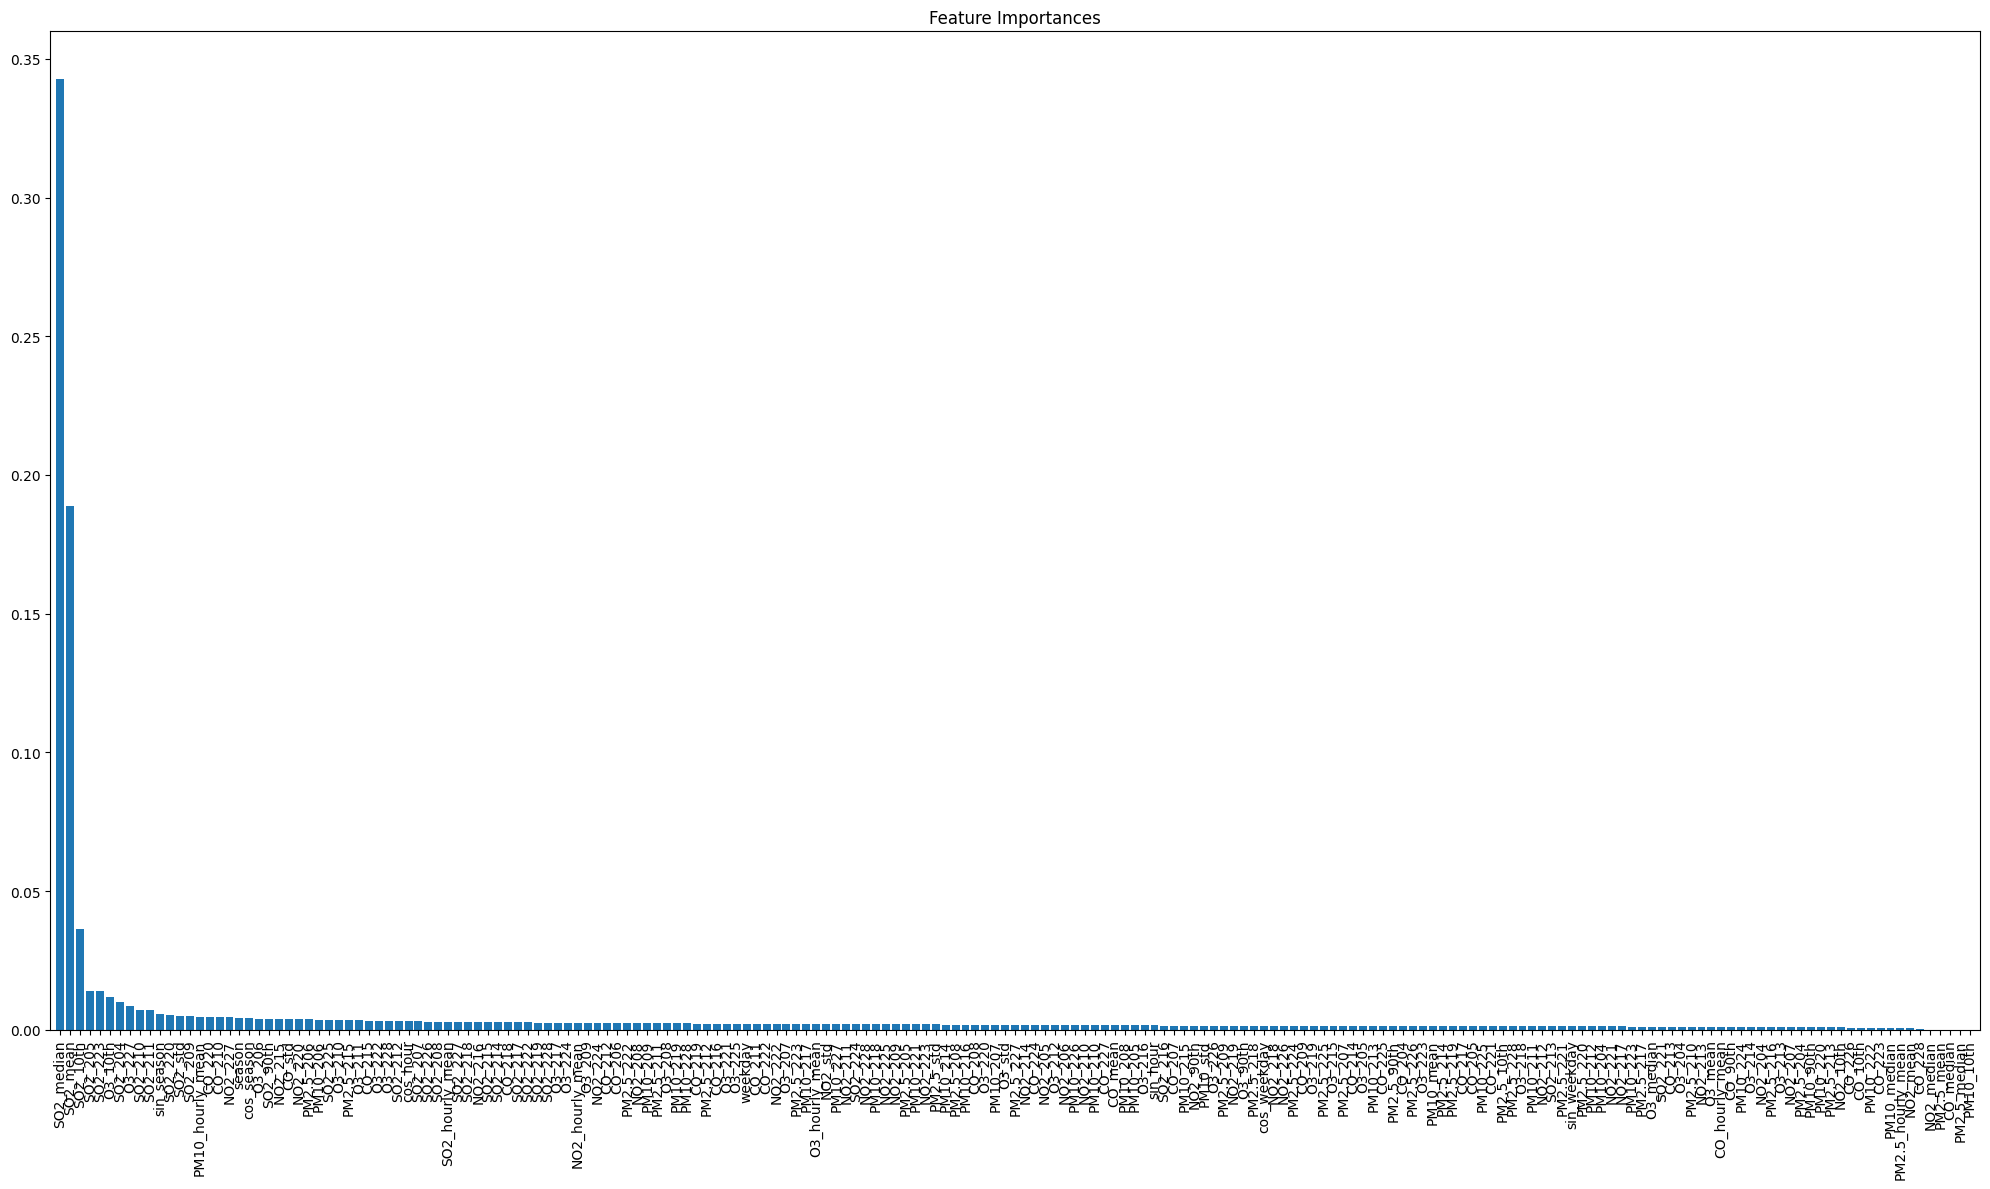

In [21]:
#features importance
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

features = df_model.drop(columns=["Measurement date", target]).columns
plt.figure(figsize=(10*2, 6*2))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()

